## 1.文件读取
notes:
- !shell command 可以再 jupyter 里面执行 shell 命令
- wiki 数据提取 >> see **corpus_processing_doc.ipnb'**
- pandas读取文件。常见中文编码方式（e.g. 'gb18030'）
- pandas对表中数据进行filter（titanic_train）>> see **linear_regression**

## 2.正则表达式
- html 文件中用正则抓取 http url
- this section **see recode in week3**

## 3.n-gram
用n-gram计算句子、短语的概率
### 3.1 词频统计 (BOW)
- calculation of BOW see **corpus_processing_doc.ipynb**
- 生成可以统计词频的函数的函数（lisp风格的变量作用于trick）
- 画出词频的分布曲线

============= 1-gram char =============
total word count of corpus: 389334319
total vocabulary count: 9727
============= 2-gram char =============
total word count of corpus: 355228867
total vocabulary count: 948930
============= 1-gram word =============
total word count of corpus: 158096450
total vocabulary count: 296756
============= 2-gram word =============
total word count of corpus: 63557530
total vocabulary count: 749114


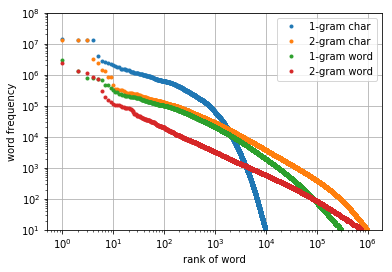

In [13]:
import matplotlib.pyplot as plt
import corpus_processing as cp
import debug_tools

count_ngram1word = cp.load_obj('data/count_ngram1word')
count_ngram2word = cp.load_obj('data/count_ngram2word')
count_ngram1char = cp.load_obj('data/count_ngram1char')
count_ngram2char = cp.load_obj('data/count_ngram2char')

legend = []
def visualize_counter(word_count, name):
    global legend
    legend.append(name)
    freq = [f for gram, f in word_count.most_common()]
    plt.figure('counter')
    plt.loglog(freq, '.')
    plt.grid(True)
    plt.xlabel('rank of word')
    plt.ylabel('word frequency')
    plt.legend(legend)
    plt.ylim([10, 10**8])
    print('=============',name,'=============')
    print('total word count of corpus:', sum(freq))
    print('total vocabulary count:', len(freq))

visualize_counter(count_ngram1char,'1-gram char')
visualize_counter(count_ngram2char,'2-gram char')
visualize_counter(count_ngram1word,'1-gram word')
visualize_counter(count_ngram2word,'2-gram word')
plt.show()

### 3.2 unigram
$\textbf{w} = w_1...w_i...w_n$

$P(\textbf{w}) = \prod_{i=1}^nP(w_i)$

In [2]:
from functools import reduce, partial
import logging
import jieba
jieba.setLogLevel(logging.WARNING)

def get_MLE_prob_from_count(count):
    total_count = sum(count.values())
    @debug_tools.debug_print
    def get_prob(w):
        return count[w]/total_count
    return get_prob

def string_ngram_prob(string, prob_func, gram_level, n):
    cp.gram_level = gram_level # this will effect the behavior of 'tokenize_string'
    probs = [prob_func(tuple(token)) for token in cp.get_ngram(string, n)]
    
    if not probs: 
        probs = [0]
    return reduce(lambda x, y: x*y , probs)

get_1gram_prob_char = partial(string_ngram_prob, 
                              prob_func=get_MLE_prob_from_count(count_ngram1char), 
                              gram_level='char', n=1)

get_1gram_prob_word = partial(string_ngram_prob, 
                              prob_func=get_MLE_prob_from_count(count_ngram1word), 
                              gram_level='word', n=1)

test cases

In [3]:
pair = """前天晚上吃晚饭的时候
前天晚上吃早饭的时候""".split('\n')

pair2 = """正是一个好看的小猫
真是一个好看的小猫""".split('\n')

pair3 = """我无言以对，简直
我简直无言以对""".split('\n')

pairs = [pair, pair2, pair3, ['广州有一个地方叫做沥窖', '杭州有一个地方叫做西湖'], ['这是一个比较常见测试用例','这是一个比较罕见的测试用例']]

def test_pair(pairs, prob_func, name_func):
    print('test function:', name_func)
    for pair in pairs:
        print('===================================')
        for sent in pair:
            print(sent, prob_func(sent))
    print('\n')
    
debug_tools.is_debug = False
test_pair(pairs, get_1gram_prob_char, 'get_1gram_prob_char')
test_pair(pairs, get_1gram_prob_word, 'get_1gram_prob_word')

test function: get_1gram_prob_char
前天晚上吃晚饭的时候 3.8350439429256126e-31
前天晚上吃早饭的时候 7.724772467291999e-31
正是一个好看的小猫 1.4986935364748715e-20
真是一个好看的小猫 4.765632570447433e-21
我无言以对，简直 4.264824123041106e-23
我简直无言以对 4.264824123041106e-23
广州有一个地方叫做沥窖 1.55608515722977e-32
杭州有一个地方叫做西湖 6.877388847319173e-29
这是一个比较常见测试用例 3.9131441795345993e-32
这是一个比较罕见的测试用例 2.4603814628944908e-33


test function: get_1gram_prob_word
前天晚上吃晚饭的时候 1.3775281090495917e-21
前天晚上吃早饭的时候 1.2329156456060136e-25
正是一个好看的小猫 2.5761218816412435e-16
真是一个好看的小猫 3.2085032220958126e-17
我无言以对，简直 6.889372468843494e-16
我简直无言以对 6.889372468843495e-16
广州有一个地方叫做沥窖 0.0
杭州有一个地方叫做西湖 1.1078347651166538e-19
这是一个比较常见测试用例 2.44250978974669e-18
这是一个比较罕见的测试用例 6.306098352969772e-19




### 3.3 bigram
$P(\textbf{w}) = \prod_{i=1}^nP(w_i|w_{i-1})= \prod_{i=1}^n\frac{P(w_{i-1},w_{i})}{P(w_{i-1})}$

In [4]:
def get_conditional_prob(numerator_func, denominator_func):
    @debug_tools.debug_print
    def get_prob(token):
        condition_token = token[:-1]
        return numerator_func(token)/denominator_func(condition_token)
    return get_prob

conditional_prob_char = get_conditional_prob(get_MLE_prob_from_count(count_ngram2char), 
                                             get_MLE_prob_from_count(count_ngram1char))

conditional_prob_word = get_conditional_prob(get_MLE_prob_from_count(count_ngram2word), 
                                             get_MLE_prob_from_count(count_ngram1word))

get_2gram_prob_char = partial(string_ngram_prob, 
                              prob_func=conditional_prob_char, 
                              gram_level='char', n=2)

get_2gram_prob_word = partial(string_ngram_prob, 
                              prob_func=conditional_prob_word, 
                              gram_level='word', n=2)

one test case show the sparsity of 2gram (words level) probablity via MLE

In [5]:
debug_tools.is_debug = True
test_pair([pairs[1]], get_2gram_prob_word, 'get_2gram_prob_word')

test function: get_2gram_prob_word
get_MLE_prob_from_count.<locals>.get_prob ((('正是', '好看'),), {}) => 0.0
get_MLE_prob_from_count.<locals>.get_prob ((('正是',),), {}) => 4.8957456033959014e-05
get_conditional_prob.<locals>.get_prob ((('正是', '好看'),), {}) => 0.0
get_MLE_prob_from_count.<locals>.get_prob ((('好看', '小猫'),), {}) => 0.0
get_MLE_prob_from_count.<locals>.get_prob ((('好看',),), {}) => 2.0240808696210447e-06
get_conditional_prob.<locals>.get_prob ((('好看', '小猫'),), {}) => 0.0
正是一个好看的小猫 0.0
get_MLE_prob_from_count.<locals>.get_prob ((('真是', '好看'),), {}) => 0.0
get_MLE_prob_from_count.<locals>.get_prob ((('真是',),), {}) => 6.097543619733397e-06
get_conditional_prob.<locals>.get_prob ((('真是', '好看'),), {}) => 0.0
get_MLE_prob_from_count.<locals>.get_prob ((('好看', '小猫'),), {}) => 0.0
get_MLE_prob_from_count.<locals>.get_prob ((('好看',),), {}) => 2.0240808696210447e-06
get_conditional_prob.<locals>.get_prob ((('好看', '小猫'),), {}) => 0.0
真是一个好看的小猫 0.0




all test cases

In [6]:
debug_tools.is_debug = False
test_pair(pairs, get_2gram_prob_char, 'get_2gram_prob_char')
test_pair(pairs, get_2gram_prob_word, 'get_2gram_prob_word')

test function: get_2gram_prob_char
前天晚上吃晚饭的时候 8.044376701016833e-19
前天晚上吃早饭的时候 8.044176890731375e-20
正是一个好看的小猫 6.102808501188787e-14
真是一个好看的小猫 2.5383867920499992e-14
我无言以对，简直 6.91685929758551e-17
我简直无言以对 7.174041746396637e-18
广州有一个地方叫做沥窖 0.0
杭州有一个地方叫做西湖 2.4312412025640827e-17
这是一个比较常见测试用例 0.0
这是一个比较罕见的测试用例 0.0


test function: get_2gram_prob_word
前天晚上吃晚饭的时候 0.0
前天晚上吃早饭的时候 0.0
正是一个好看的小猫 0.0
真是一个好看的小猫 0.0
我无言以对，简直 0.0
我简直无言以对 0.0
广州有一个地方叫做沥窖 0.0
杭州有一个地方叫做西湖 0.0
这是一个比较常见测试用例 0.0
这是一个比较罕见的测试用例 0.0




## 3.Good–Turing frequency estimation
visuialize relation ship between $c$ and $N_c$

reference: https://www.wikiwand.com/en/Good%E2%80%93Turing_frequency_estimation

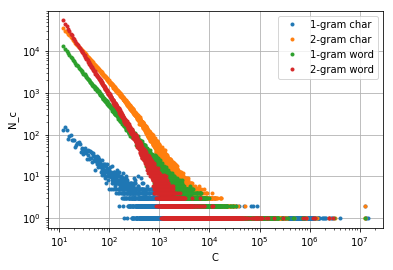

In [7]:
from collections import defaultdict, Counter
import numpy as np

legend = []
def count_Nc_from_gram_count(count):
#     def get_Nc_from_c(c, count):
#         selected_grams = list(filter(lambda x:x[1] == c, count.items()))
#         return len(selected_grams)
#     c_max = count.most_common(1)[0][1]
#     N_c = [get_Nc_from_c(c, count) for c in range(c_max+1)] #too complex
# use sorting technics solve this question

    c = count.most_common(1)[0][1]
    N_c = 0
    Nc_pairs = []
    for gram, f in count.most_common():
        if f != c:
            Nc_pairs.append((c, N_c))
            c, N_c = f, 1
        else:
            N_c += 1
    return defaultdict(int, Nc_pairs)

c_to_Nc_ngram1char = count_Nc_from_gram_count(count_ngram1char)
c_to_Nc_ngram2char = count_Nc_from_gram_count(count_ngram2char)
c_to_Nc_ngram1word = count_Nc_from_gram_count(count_ngram1word)
c_to_Nc_ngram2word = count_Nc_from_gram_count(count_ngram2word)

def visiualize_Nc_from_count(count_Nc, name):
    c_list, Nc_list = tuple(zip(*count_Nc.items()))
    legend.append(name)
    plt.figure('Nc')
    plt.loglog(c_list, Nc_list, '.')
    plt.xlabel('C')
    plt.ylabel('N_c')
    plt.grid(True)
    plt.legend(legend)

visiualize_Nc_from_count(c_to_Nc_ngram1char,'1-gram char')
visiualize_Nc_from_count(c_to_Nc_ngram2char,'2-gram char')
visiualize_Nc_from_count(c_to_Nc_ngram1word,'1-gram word')
visiualize_Nc_from_count(c_to_Nc_ngram2word,'2-gram word')
plt.show()

implement Turing estimation, compare the graph below with

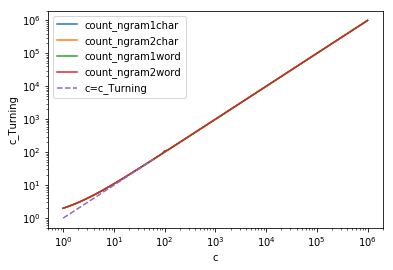

In [8]:
def Turing_smooth(c, c_to_Nc):
    return (c + 1)*(c_to_Nc[c] + 1)/(c_to_Nc[c+1] + 1) #here the smooth function S(N) = N + 1

legend = []
def Turing_estimation_from_count(count, name):
    global legend
    legend.append(name)
    
    c_to_Nc = count_Nc_from_gram_count(count)
    result = {gram: Turing_smooth(c, c_to_Nc) for gram, c in count.items()}
    if True:
        C = np.logspace(0, 6, num=100, base=10)
        C_Turning = [Turing_smooth(c, c_to_Nc) for c in C]
        plt.figure('Turning_smooth')
        plt.loglog(C, C_Turning)
    return defaultdict(lambda :1,result)
    
    
count_ngram1char_Turing = Turing_estimation_from_count(count_ngram1char, 'count_ngram1char')
count_ngram2char_Turing = Turing_estimation_from_count(count_ngram2char, 'count_ngram2char')
count_ngram1word_Turing = Turing_estimation_from_count(count_ngram1word, 'count_ngram1word')
count_ngram2word_Turing = Turing_estimation_from_count(count_ngram2word, 'count_ngram2word')

plt.figure('Turning_smooth')
plt.loglog([1,10*6],[1,10*6],'--')
plt.xlabel('c')
plt.ylabel('c_Turning')
legend.append('c=c_Turning')
plt.legend(legend)
plt.show()


apply to unigram and bigram

In [9]:
#unigram
get_1gram_prob_char_Turing = partial(string_ngram_prob, 
                              prob_func=get_MLE_prob_from_count(count_ngram1char_Turing), 
                              gram_level='char', n=1)

get_1gram_prob_word_Turing = partial(string_ngram_prob, 
                              prob_func=get_MLE_prob_from_count(count_ngram1word_Turing), 
                              gram_level='word', n=1)

#bigram
conditional_prob_char_Turing = get_conditional_prob(get_MLE_prob_from_count(count_ngram2char_Turing), 
                                                    get_MLE_prob_from_count(count_ngram1char_Turing))

conditional_prob_word_Turing = get_conditional_prob(get_MLE_prob_from_count(count_ngram2word_Turing), 
                                                    get_MLE_prob_from_count(count_ngram1word_Turing))

get_2gram_prob_char_Turing = partial(string_ngram_prob, 
                                     prob_func=conditional_prob_char_Turing, 
                                     gram_level='char', n=2)

get_2gram_prob_word_Turing = partial(string_ngram_prob, 
                                     prob_func=conditional_prob_word_Turing, 
                                     gram_level='word', n=2)

one test case

In [10]:
debug_tools.is_debug = True
test_pair([pairs[1]], get_2gram_prob_word_Turing, 'get_2gram_prob_word_Turing')

test function: get_2gram_prob_word_Turing
get_MLE_prob_from_count.<locals>.get_prob ((('正是', '好看'),), {}) => 1.114396844210098e-08
get_MLE_prob_from_count.<locals>.get_prob ((('正是',),), {}) => 5.5805206398171325e-05
get_conditional_prob.<locals>.get_prob ((('正是', '好看'),), {}) => 0.00019969406371492528
get_MLE_prob_from_count.<locals>.get_prob ((('好看', '小猫'),), {}) => 1.114396844210098e-08
get_MLE_prob_from_count.<locals>.get_prob ((('好看',),), {}) => 1.1171531680990245e-06
get_conditional_prob.<locals>.get_prob ((('好看', '小猫'),), {}) => 0.009975327251735618
正是一个好看的小猫 1.992013635785323e-06
get_MLE_prob_from_count.<locals>.get_prob ((('真是', '好看'),), {}) => 1.114396844210098e-08
get_MLE_prob_from_count.<locals>.get_prob ((('真是',),), {}) => 2.845933797419396e-06
get_conditional_prob.<locals>.get_prob ((('真是', '好看'),), {}) => 0.0039157511155761895
get_MLE_prob_from_count.<locals>.get_prob ((('好看', '小猫'),), {}) => 1.114396844210098e-08
get_MLE_prob_from_count.<locals>.get_prob ((('好看',),), {})

whole test cases

In [11]:
debug_tools.is_debug = False
test_pair(pairs, get_1gram_prob_char_Turing, 'get_1gram_prob_char_Turing')
test_pair(pairs, get_1gram_prob_word_Turing, 'get_1gram_prob_word_Turing')
test_pair(pairs, get_2gram_prob_char_Turing, 'get_2gram_prob_char_Turing')
test_pair(pairs, get_2gram_prob_word_Turing, 'get_2gram_prob_word_Turing')

test function: get_1gram_prob_char_Turing
前天晚上吃晚饭的时候 2.8704009986370682e-31
前天晚上吃早饭的时候 5.781689965664945e-31
正是一个好看的小猫 1.2354211287023462e-20
真是一个好看的小猫 3.928484883881363e-21
我无言以对，简直 3.404081658838335e-23
我简直无言以对 3.404081658838335e-23
广州有一个地方叫做沥窖 1.1663086073467041e-32
杭州有一个地方叫做西湖 5.147240433398129e-29
这是一个比较常见测试用例 2.835733588726984e-32
这是一个比较罕见的测试用例 1.7830362419319867e-33


test function: get_1gram_prob_word_Turing
前天晚上吃晚饭的时候 6.616649276429155e-22
前天晚上吃早饭的时候 6.710133530173703e-26
正是一个好看的小猫 7.432737903506603e-17
真是一个好看的小猫 3.790520880080965e-18
我无言以对，简直 1.6583963923160534e-16
我简直无言以对 1.6583963923160534e-16
广州有一个地方叫做沥窖 1.7843566465118832e-22
杭州有一个地方叫做西湖 1.0659011700128659e-19
这是一个比较常见测试用例 2.261840278939012e-18
这是一个比较罕见的测试用例 5.840485939845026e-19


test function: get_2gram_prob_char_Turing
前天晚上吃晚饭的时候 5.268087731731447e-20
前天晚上吃早饭的时候 5.107190506962257e-21
正是一个好看的小猫 1.0758780044905439e-14
真是一个好看的小猫 2.4952918225221974e-15
我无言以对，简直 5.109717010789242e-18
我简直无言以对 7.600070781385153e-19
广州有一个地方叫做